# Вариант 1:
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данны

In [48]:
# Импорт необходимы библиотек
import pandas as pd
import numpy as np
from operator import attrgetter
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

from scipy.stats import norm
from tqdm.auto import tqdm
import scipy.stats as ss


In [49]:
 # данные о времени захода пользователей в игру 
def retention_rate (auth_df_path, reg_df_path, min_date = '', max_date = ''):
    path_2 = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-holodkov-20/shared/problem1-reg_data.csv"
    path = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-holodkov-20/shared/problem1-auth_data.csv"
    auth_df = pd.read_csv(path, sep= ';')
    # данные о времени регистрации
    reg_df = pd.read_csv(path_2, sep= ';')
    
    # Конвертируем дату из Timestamp в привычный формат
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'],unit='s')
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'],unit='s')
     
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'].dt.date)
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'].dt.date)  
    
    # Объеденим датафреймы reg_data и auth_data
    all_df = reg_df.merge(auth_df, on='uid')
   
    # Фильтруем дату
    all_df =  all_df.query('reg_ts >= @min_date & reg_ts <= @max_date')
    
    # Создаёс дата фрейм с уникальными пользователями
    cohort = all_df.groupby(['reg_ts', 'auth_ts'], as_index = False).agg({'uid' : 'nunique'})
    
    # Cчитаем разницу захода и регистрации, активные дни пользователя
    cohort['сount_day'] = (cohort['auth_ts'] - cohort['reg_ts']).apply(attrgetter('days'))
    
    # Переведем дату в тип "строка" для наглядного отображения на графике
    cohort['reg_ts'] = cohort['reg_ts'].astype('str')
    
    #Перестроение таблицы
    cohort = cohort.pivot(index = 'reg_ts', columns = 'сount_day', values = 'uid')
    
    # Расчёт ретеншен
    retention_rate = cohort.div(cohort.iloc[:, 0], axis = 0)
    
    # Сделаем красиво
    style = (retention_rate
            .style
            .set_caption('User retention by cohort')  
            .background_gradient(axis=None,vmin=0.0, vmax=0.1)  
            .highlight_null('white')  
            .format("{:.2%}", na_rep=''))
    return style

In [50]:
retention_rate('path_2','path', min_date = '2020-09-01',max_date = '2020-09-23')

сount_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%
2020-09-02,100.00%,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%,4.16%,4.85%,3.90%,3.72%,4.66%,2.64%,
2020-09-03,100.00%,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%,4.40%,4.84%,4.65%,5.47%,2.39%,,
2020-09-04,100.00%,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%,4.52%,4.27%,4.77%,2.64%,,,
2020-09-05,100.00%,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%,4.45%,4.76%,2.51%,,,,
2020-09-06,100.00%,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%,4.82%,2.56%,,,,,
2020-09-07,100.00%,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%,3.37%,,,,,,
2020-09-08,100.00%,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%,,,,,,,
2020-09-09,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%,,,,,,,,


# Задание 2.
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [51]:
# Загрузим данные
df_ab = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep = ';')
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [52]:
df_ab.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [53]:
df_ab['user_id'].nunique()
# Судя по всему все пользователи в сете уникальны

404770

In [54]:
df_ab['user_id'].nunique()
# Судя по всему все пользователи в сете уникальны

404770

In [55]:
# найдём основные метрики:
df_metric = df_ab.groupby('testgroup')\
                 .agg({'revenue':'sum','user_id':'nunique'})\
                 .rename(columns={'user_id': 'users'})

In [56]:
# найдём платящих пользователей
df_metric['paying_users'] = df_ab[df_ab['revenue'] > 0].groupby('testgroup').agg({'user_id' : 'nunique'})

In [57]:
# найдём ARPU (сколько денег в среднем приносит компании один пользователь за определенный промежуток времени)
df_metric['ARPU'] = round(df_metric['revenue'] / df_metric['users'] ,2)

In [58]:
# надём ARPPU (сколько денег в среднем приносит компании один Платящий пользователь за определенный промежуток времени)
df_metric['ARPPU'] = round(df_metric['revenue'] / df_metric['paying_users'] ,2)

In [59]:
# добавим медианную выручку на всех пользователей назовём её ARPU_Median
df_metric['ARPU_Median'] = df_ab.groupby('testgroup').agg({'revenue':'median'})

In [60]:
# добавим медианную выручку на Платящего пользователя назовём её ARPPU_Median
df_metric['ARPPU_Median'] = df_ab[df_ab['revenue'] > 0].groupby('testgroup').agg({'revenue':'median'})

In [61]:
# и последжнее найдём конверсию среди платящих пользователей
df_metric['conversion_rate'] = round((df_metric['paying_users'] / df_metric['users']) * 100, 2)

In [62]:
df_metric

,revenue,users,paying_users,ARPU,ARPPU,ARPU_Median,ARPPU_Median,conversion_rate
testgroup,,,,,,,,
a,5136189,202103,1928,25.41,2664.00,0,311,0.95
b,5421603,202667,1805,26.75,3003.66,0,3022,0.89


In [63]:
# проверим условие (найдём разницу ARPU )
print(f"ARPU в тестовой группе больше на {((df_metric.loc['b','ARPU'] - df_metric.loc['a','ARPU']) * 100 / df_metric.loc['b','ARPU']):.1f}%, чем в контрольной")

ARPU в тестовой группе больше на 5.0%, чем в контрольной


In [64]:
# найёдм разницу ARPPU
print(f"ARPPU в тестовой группе больше на {((df_metric.loc['b','ARPPU'] - df_metric.loc['a','ARPPU']) *100 / df_metric.loc['b','ARPPU']):.1f}%, чем в контрольной")

ARPPU в тестовой группе больше на 11.3%, чем в контрольной


In [65]:
# найёдм разницу ARPPU медиан
print(f"ARPPU_Median в тестовой группе больше на {((df_metric.loc['b','ARPPU_Median'] - df_metric.loc['a','ARPPU_Median']) *100 / df_metric.loc['b','ARPPU_Median']):.1f}%, чем в контрольной")

ARPPU_Median в тестовой группе больше на 89.7%, чем в контрольной


In [66]:
# Отдельно посмотрим на платящих пользователй
paying_users = df_ab.query('revenue > 0')
paying_users.head(3)

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a


In [67]:
# Посмотрим на данные в разрезе по группе А
paying_users.query('testgroup == "a"')['revenue'].describe().to_frame()

,revenue
count,1928.000000
mean,2663.998444
std,9049.039763
min,200.000000
25%,257.000000
50%,311.000000
75%,361.000000
max,37433.000000


In [68]:
# Посмотрим на данные в разрезе по группе B
paying_users.query('testgroup == "b"')['revenue'].describe().to_frame()

,revenue
count,1805.000000
mean,3003.658172
std,572.619709
min,2000.000000
25%,2513.000000
50%,3022.000000
75%,3478.000000
max,4000.000000


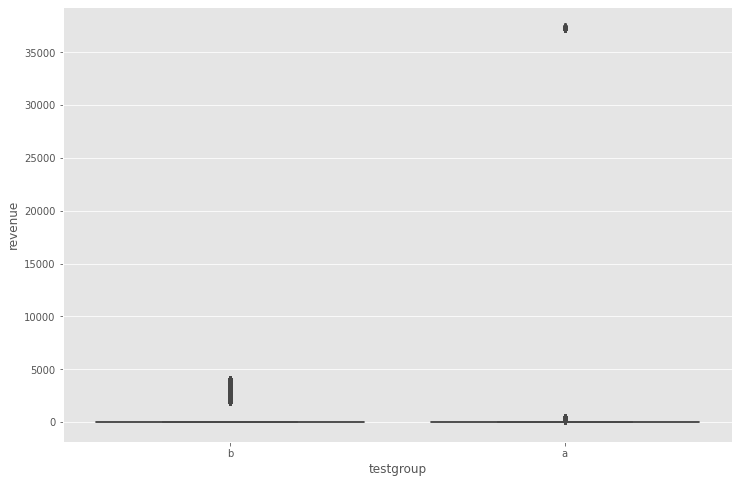

In [69]:
# посмотрим на boxplot
plt.figure(figsize = (12,8))
sns.boxplot(x = 'testgroup', y = 'revenue', data = df_ab)

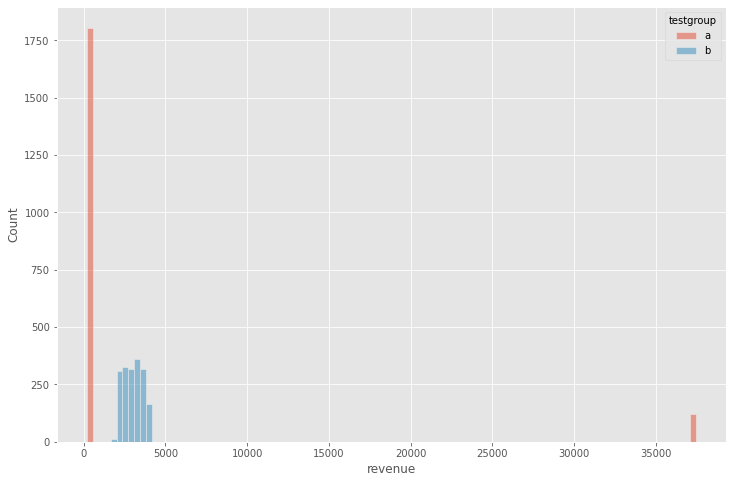

In [70]:
# Посмотрим на выручку в виде графика                            
plt.figure(figsize = (12,8))
sns.histplot(data = paying_users, x = "revenue", hue = "testgroup")  

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


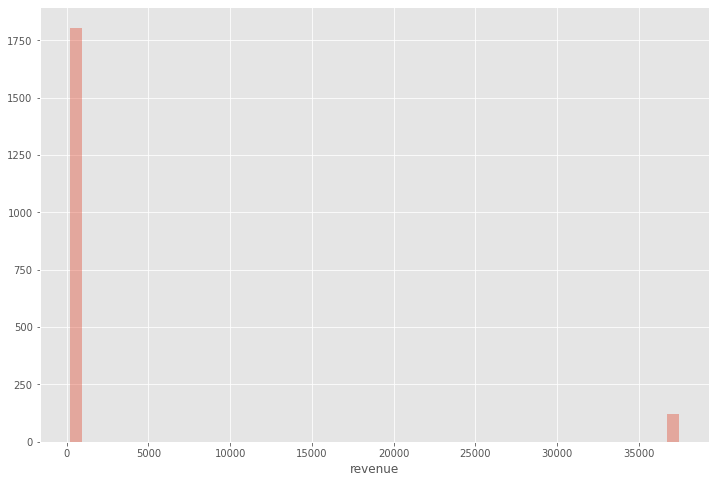

In [71]:
# Отдельно на группу а
plt.figure(figsize = (12,8))
sns.distplot(paying_users[paying_users.testgroup == 'a'].revenue, kde = False)  

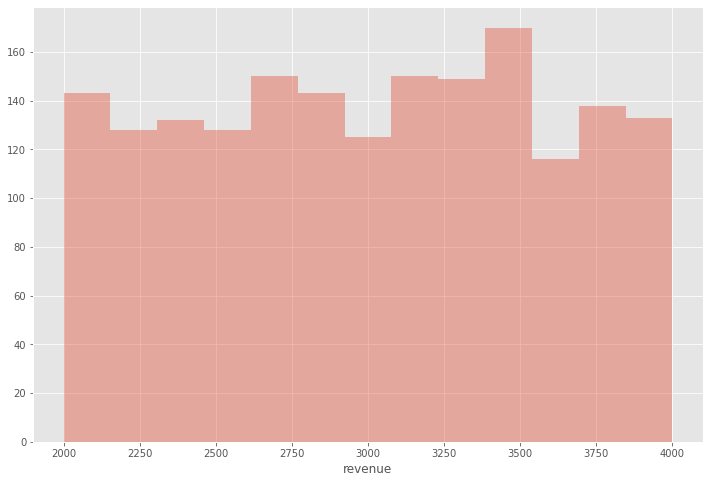

In [72]:
# Отдельно по групе б
plt.figure(figsize = (12,8))
sns.distplot(paying_users[paying_users.testgroup == 'b'].revenue, kde = False)

### Изучив данные мы видим большие выбросы в контрольной группе 'a', посмотрим поближе, что за пользователи и попробуем понять с чем это связано.

In [73]:
group_a = paying_users[paying_users.testgroup == 'a'] 

In [74]:
# количество пользователей в контрольной группе заплатившие больше 35000
group_a.query('revenue > 35000').shape[0]

123

In [75]:
# Найдём, процент данных пользователей от общей выручки
group_a.query('revenue > 35000').revenue.sum() / group_a.revenue.sum() 

0.8937077665950377

In [76]:
# Посмотрим есть ли данные пользователи в тестовой группе б
fd = df_ab.pivot(index = 'user_id', columns = 'testgroup', values = 'revenue').reset_index()

In [77]:
fd.query('a > 35000')

testgroup,user_id,a,b
416,417,37324.0,NaN
4428,4429,37304.0,NaN
5777,5778,37315.0,NaN
8065,8066,37307.0,NaN
8743,8744,37334.0,NaN
...,...,...,...
360696,360697,37347.0,NaN
378668,378669,37297.0,NaN
389341,389342,37298.0,NaN
394580,394581,37302.0,NaN


In [78]:
fd.query('a > 35000').b.sum()

0.0

 Посмотрев выбросы, можно предположить, 123 игрока являются 'китами', которые делают 89% всей доли revenue в контрольной группе 'a',таких пользователей нужно беречь. Выбросы могут быть связанны с не сбалансированностью акционных предложей и супер дорогих фичей, за которые готовы платить малая часть пользователей. 
 
Так же я выянсил, что пользователи 'киты' отсутсвует в тестовой группе 'b'.

Данные имеют сильные выбросы, в качестве оценщика теста будем использовать бустрап, он универсален и позволяет считать разную статистику , и  выбросы ему не страшны

### Гипотезы:
**H0** - Различий в данных нет\
**Н1** - Различия в данных есть

In [79]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

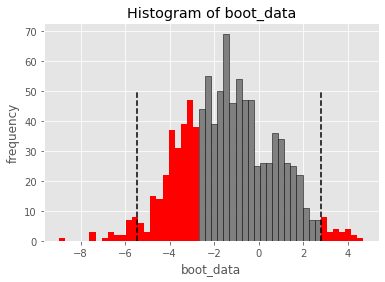

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


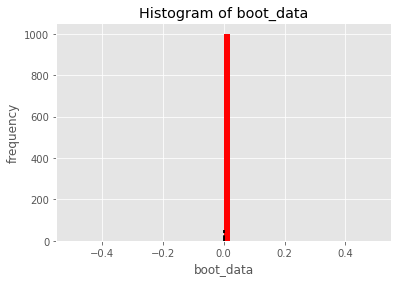

ARPU: 0.5040424403783907, ARPU_median :nan


In [80]:
# Применение бустрап с np.mean и np.median для всех пользователей и сравним p.v-value
x = df_ab[df_ab.testgroup == 'a'].revenue
y = df_ab[df_ab.testgroup == 'b'].revenue

res_a_npmean = get_bootstrap(x,y)
res_a_npmed = get_bootstrap(x ,y, statistic = np.median)
    
print (f'ARPU: {res_a_npmean["p_value"]}, ARPU_median :{res_a_npmed["p_value"]}')

In [81]:
print(f"Доверительный интервал при применении бутстрэпа для разности медиан всех пользователей: {res_a_npmed['quants']}")

Доверительный интервал при применении бутстрэпа для разности медиан всех пользователей:          0
0.025  0.0
0.975  0.0


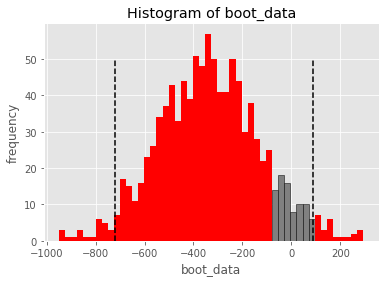

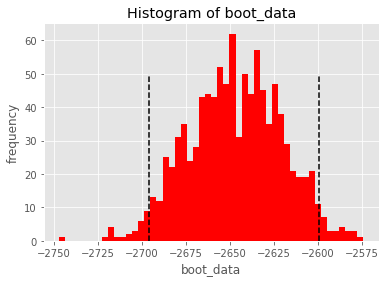

ARPPU: 0.10428167702770401, ARPPU_median :0.0


In [82]:
# Применение бустрап с np.mean и np.median и для платящих пользователей сравним p.v-value
x = paying_users[paying_users.testgroup == 'a'].revenue
y = paying_users[paying_users.testgroup == 'b'].revenue

res_a_npmean_pay = get_bootstrap(x,y)
res_a_npmedian_pay = get_bootstrap(x ,y, statistic = np.median)
    
print (f'ARPPU: {res_a_npmean_pay["p_value"]}, ARPPU_median :{res_a_npmedian_pay["p_value"]}')

In [83]:
print(f"Доверительный интервал при применении бутстрэпа для разности медиан платящих пользователей: {res_a_npmedian_pay['quants']}")

Доверительный интервал при применении бутстрэпа для разности медиан платящих пользователей:               0
0.025 -2696.000
0.975 -2599.475


#### Результаты сравнения:
#### ARPU 
Результат теста показал p_palue > 0.05, значит между группами не обнаружено статически значимой разницы.
#### ARPPU 
Результат теста так же показал p_palue > 0.05, и стат значимой разницы  не найдено
#### ARPU_median и ARPPU_median 
Результат теста показал p_value < 0.05, что является потдверждением альтернативной гипотезы, между группами есть стат значимая разница

Зная, что среднему распрелению не хватает эффективности в качестве оценки распределений, поскольку выбросы меняют его. Медианна же напротив устойчива к выбросам, имено поэтому возьмём в основной вывод результат теста с медианной, а именно что между группами "а" и "б" есть стат значимые различия

### Вывод
Я считаю что наборы акционных предложений в тестовой группе б лучше чем в контрольной a.

За счёт более сбалансированных акционных предложей , возможность привлеч пользователей к большим тратам привели к увеличению прибыли. Не смотря на снижение конверсии , как оказалось пользователей "китов" нет в тестовой группе, стоит рассмотреть отдельные условия или фичи для данных пользхователей, чтобы не потрять их и ещё больше увеличть продажи.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


`Метрики, которые необходимо отслеживать:`
 - DAU
 - Sticky Factor
 - Retention 
 - Total Daily Play Time


1. **DAU** (Daily Active Users - число пользоватей, которые заходили в игру в определенный день)будем отслеживать для того, что бы отслеживать нравится ли пользователям наше текущее тематическое событие. DAU не должен падать

2. Стоит также измерить **Sticky Factor** (коэффициент «липучести» = среднее DAU/MAU)за текущий месяц проведения тематического события и сравнить с данными по этой метрике за предыдущие периоды. Ожидаем, что Sticky Factor увеличится, то есть это будет означать, что пользователям понравилось данное событие и они регулярно заходили в течение месяца проведения события.

3. Стоит отслеживать **Retention Rate** (коэффициент удержания пользователей) по когортам, ожидаем, что Retention Rate будет не падать, то есть пользователи регулярно будут возвращаться в игру.

4. **Total Daily Play Time** также будем ожидать, что увеличится, то есть пользователи будут дольше находится в игре, что означает, что им нравится данное событие.

*Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?*

Можно оставить выше уже перечисленные метрики, добавив разделение на пользователей, которые откатились на несколько уровней назад N раз. Интересно посмотреть на их поведение с течением времени, если их метрики будут меньше/падать с течением времени в отличие от пользователей, которые проходят уровни без неудачных попыток, то это будет означать, что пользователям не нравится, что их откидывает назад и им по много раз приходится проходить одни и те же уровни, и есть риск их потерять.

Также в любых случаях и вариантах монетизации, обязательно необходимо смотреть на финансовые метрики в абсолютных выражениях и в динамике:\
**LTV**\
**ARPU**\
**ARPPU**\
**Paying Share**\
**Revenue**